<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'D:\Coursera\ML MIRT-Yandex\c6\data'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
from collections import Counter
import datetime
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):

    with open(site_freq_path, 'rb') as f:
        site_dict = pickle.load(f)
        
    for site in site_dict.keys():
        site_dict[site] = site_dict[site][0]        

    lines = []
    to_sec = np.timedelta64(1, 's')
    ts_offset = np.datetime64('1970-01-01T00:00:00Z')
    c = Counter()
    for file in sorted(glob(path_to_csv_files + '\*.csv')):
        data = pd.read_csv(file, parse_dates=['timestamp'])
        sites = [site_dict[site] for site in data.site]
        dates = data.timestamp.values
        userid = int(file[-8:-4])
        for session_start in range(0, len(sites), window_size):
            line = sites[session_start:session_start + session_length]
            session_dates = dates[session_start:session_start + session_length]
            start_time = session_dates.min()
            time = int(((session_dates.max()) - start_time) / to_sec)
            start_time = datetime.datetime.utcfromtimestamp((start_time - ts_offset) / to_sec)
            c.clear()
            c.update(line)
            if len(line) < session_length:
                line += [0] * (session_length - len(line))
            line += [time, len(c), start_time.hour, start_time.weekday(), userid]
            lines.append(line)
    
    return pd.DataFrame(lines, columns=feature_names)

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'user_id']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,3,2,2,7,2,1,8,5,9,10,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users  = prepare_train_set_with_fe(
    os.path.join(PATH_TO_DATA, '10users'), 
    site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
    feature_names=feature_names, 
    session_length=10)

Wall time: 583 ms


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,192,574,133,3,133,133,3,133,203,133,33,5,8,4,31
1,415,193,674,254,133,31,393,3305,217,55,284,10,8,4,31
2,55,3,55,55,5,293,415,333,897,55,258,7,8,4,31
3,473,3306,473,55,55,55,55,937,199,123,30,6,8,4,31
4,342,55,5,3307,258,211,3308,2086,675,2086,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users  = prepare_train_set_with_fe(
    os.path.join(PATH_TO_DATA, '150users'), 
    site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
    feature_names=feature_names, 
    session_length=10)

Wall time: 5.92 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']
new_features_10users = train_data_10users[new_features]
new_features_10users.head()

,session_timespan,#unique_sites,start_hour,day_of_week
0,33,5,8,4
1,284,10,8,4
2,258,7,8,4
3,30,6,8,4
4,6,9,8,4


In [10]:
new_features_10users = train_data_10users[new_features]
new_features_150users = train_data_150users[new_features]

In [11]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [12]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['user_id'] = train_data_10users['user_id'].map(id_name_dict)

In [13]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

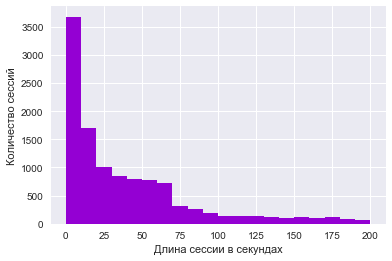

In [14]:
a = train_data_10users['session_timespan']
plot = a[a<=200].hist(color='darkviolet', bins=20)
plot.set_xlabel('Длина сессии в секундах')
plot.set_ylabel('Количество сессий')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

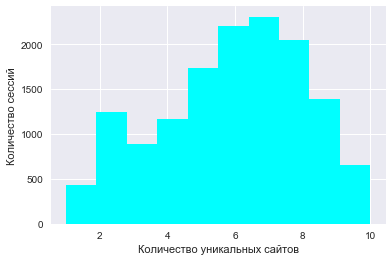

In [15]:
plot = train_data_10users['#unique_sites'].hist(color='aqua', bins=10)
plot.set_xlabel('Количество уникальных сайтов')
plot.set_ylabel('Количество сессий')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

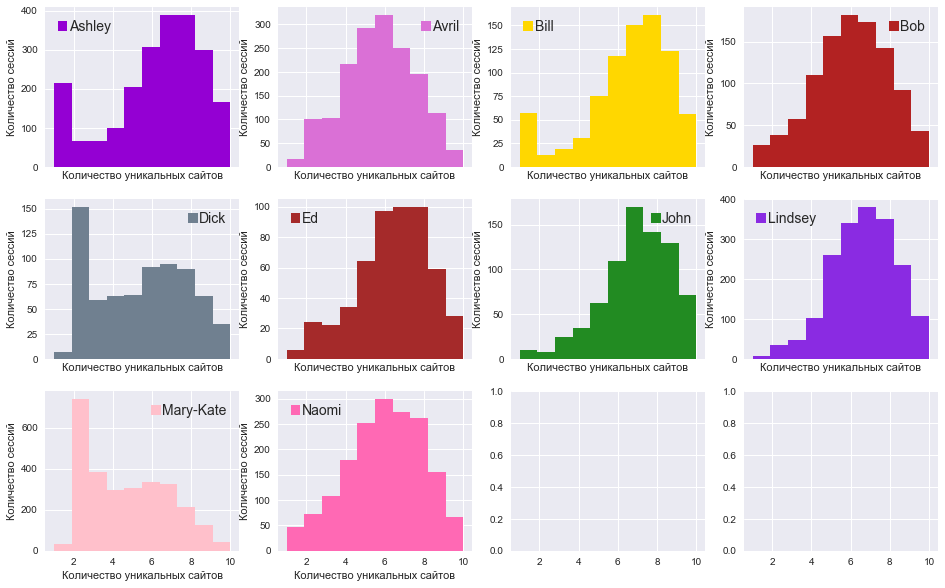

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharex=True)

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    plot = sub_df['#unique_sites'].hist(color=color_dic[user], bins=10, ax=axes[idx // 4, idx % 4])
    plot.set_xlabel('Количество уникальных сайтов')
    plot.set_ylabel('Количество сессий')
    plot.legend([user], handlelength=0.7, fontsize=14, handletextpad=0.1)

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

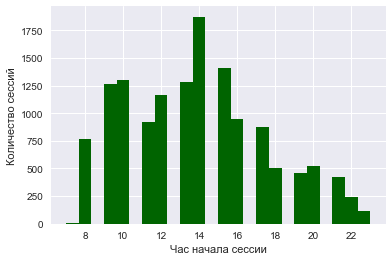

In [17]:
plot = train_data_10users['start_hour'].hist(color='darkgreen', bins=24)
plot.set_xlabel('Час начала сессии')
plot.set_ylabel('Количество сессий')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

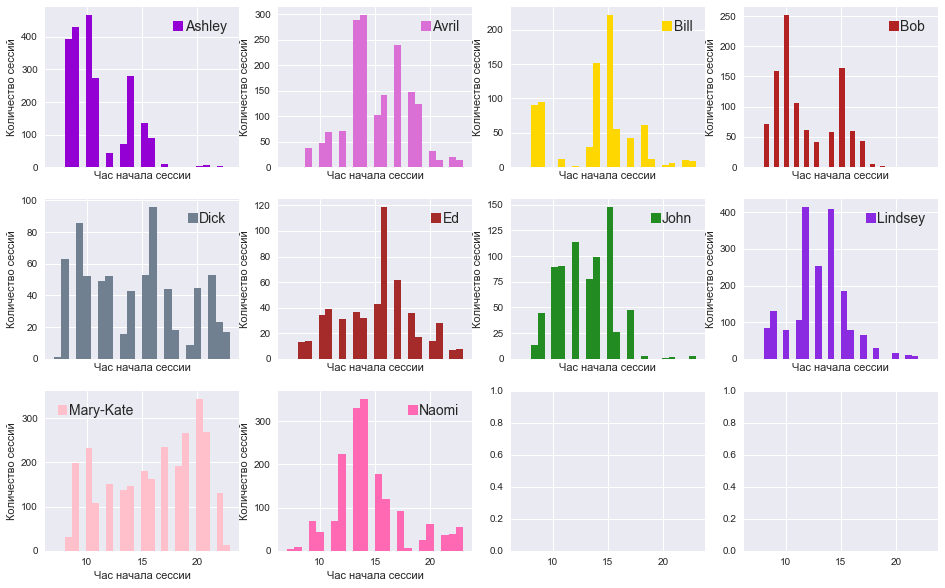

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharex=True)

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    plot = sub_df['start_hour'].hist(color=color_dic[user], bins=24, ax=axes[idx // 4, idx % 4])
    plot.set_xlabel('Час начала сессии')
    plot.set_ylabel('Количество сессий')
    plot.legend([user], handlelength=0.7, fontsize=14, handletextpad=0.1)

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

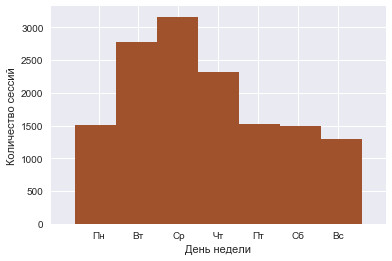

In [19]:
plot = train_data_10users['day_of_week'].hist(color='sienna', bins=7)
plot.set_xlabel('День недели')
plot.set_ylabel('Количество сессий')
plot.set_xbound(-0.5, 6.5)
plot.set_xticks([0.5, 1.33, 2.17, 3, 3.83, 4.67, 5.5])
p = plot.set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

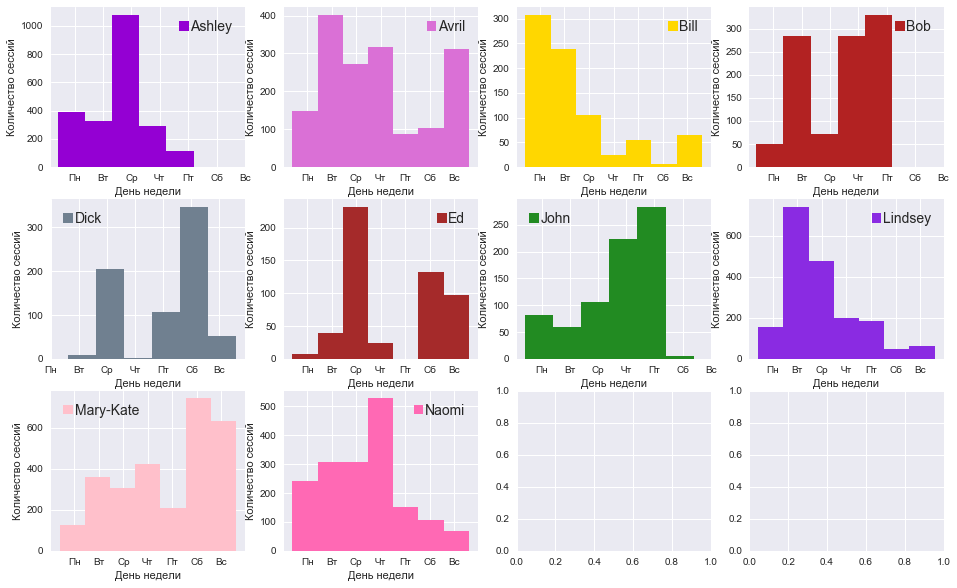

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    a = sub_df['day_of_week']
    plot = a.hist(color=color_dic[user], bins=a.max() - a.min() + 1, ax=axes[idx // 4, idx % 4])
    plot.set_xlabel('День недели')
    plot.set_ylabel('Количество сессий')
    plot.legend([user], handlelength=0.7, fontsize=14, handletextpad=0.1)
    plot.set_xticks([0.5, 1.33, 2.17, 3, 3.83, 4.67, 5.5])
    plot.set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Ashley:  
Иногда посещает только один сайт за сессию  
В основном активна утром и немнгого середине дня  
Не активна в выходные  

Avril:  
Обычно посещает 5-6 сайтов за сессию  
Более активна в середине дня  
Активна всю неделю  

Bill:  
Обычно посещает 6-7 сайтов за сессию, иногда только один  
Активен в середине и иногда с утра  
Более активен в начале недели, не активен в субботу  

Bob:  
Обычно посещает 4-7 сайтов за сессию  
В основном активен утром, немного в середине дня  
Не активен в выходные, мло активен в понедельник  

Dick:  
Часто посещает 2 сайта за сессию  
Активен на протяжении всего дня  
Не активен в понедельник, вторник и четверг  

Ed:  
Обычно посещает 6-8 сайтов за сессию  
Активен на протяжении всего дня  
Не актовен в понедельник и пятницу  

John:  
Обычно посещает 7-9 сайтов за сессию  
Более активен в первой половине дня  
Не активен в выходные  

Lindesy:  
Обычно посещает 6-8 сайтов за сессию  
Более активна утром и в первой половине дня  
Мало-активна в выходные, обычно активна во вторник-среду  

Mary-Kate:  
Часто посещает 2 сайта за сессию  
Активна весь день, но больше вечером  
Более всего активна в выходные  

Naomi:  
Обычно посещает 5-8 сайтов за сессию  
В основном активна в середине дня  
Активна всю неделю, в выходные чуть меньше  

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [21]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    site_freq_10 = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [22]:
lst = sorted([(s, site_freq_10[s][1]) for s in site_freq_10.keys()], key=lambda x: -site_freq_10[x[0]][1])[:10]
top10_freqs = [x[1] for x in lst[:10]]
top10_sites = [x[0] for x in lst[:10]]
print(top10_freqs)
print(top10_sites)

[8300, 7813, 5441, 4158, 4141, 3758, 3244, 3094, 2630, 2089]
['s.youtube.com', 'www.google.fr', 'www.google.com', 'mail.google.com', 'www.facebook.com', 'apis.google.com', 'r3---sn-gxo5uxg-jqbe.googlevideo.com', 'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'plus.google.com', 'accounts.google.com']


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

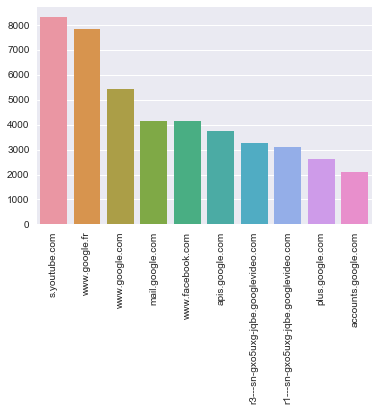

In [23]:
p = sns.barplot(x=top10_sites, y=top10_freqs).set_xticklabels(top10_sites, rotation=90)

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [24]:
print(train_data_10users['session_timespan'].median())

37.0


**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [25]:
print(train_data_10users['day_of_week'].median())

2.0


**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [26]:
print(train_data_150users['start_hour'].median())

13.0


**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [27]:
print(train_data_150users['#unique_sites'].median())

7.0


## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [28]:
# Как видно из предидущего анализа, чаще всего сайты повторяются за сессию хоть раз.
# Давайте попробуем померять "привычки" пользователя.
# Предлагается померять, как скоро пользователь заходит повторно на тот же сайт - сразу же или спустя какое-то время.
# Время предлагается мерять в секундах и "в сайтах" - то есть сколько других сайтов пользователь посетил 
# прежде чем снова зайти на данный
# Также предлагается мерять количество таких повторных заходов на сайты, между которыми прошло: 
# 1. Меньше минуты
# 2. От минуты до 15 минут
# 2. От 15 минут до получаса
# 4. Больше получаса

def feature_engineering(path_to_csv_files, site_freq_path, session_length=10, window_size=10):

    with open(site_freq_path, 'rb') as f:
        site_dict = pickle.load(f)
        
    for site in site_dict.keys():
        site_dict[site] = site_dict[site][0]        

    lines = []
    to_sec = np.timedelta64(1, 's')
    for file in sorted(glob(path_to_csv_files + '\*.csv')):
        data = pd.read_csv(file, parse_dates=['timestamp'])
        sites = [site_dict[site] for site in data.site]
        dates = data.timestamp.values
        userid = int(file[-8:-4])
        for session_start in range(0, len(sites), window_size):
            session = sites[session_start:session_start + session_length]
            num_repeat = 0
            sum_dist = 0
            max_dist = 0
            max_dist_sec = 0
            sum_dist_sec = 0
            sum_same_min = 0
            sum_same_15min = 0
            sum_same_halfhour = 0
            sum_same_rest = 0
            for i, site in enumerate(session):
                dist = next((idx for idx, val in np.ndenumerate(session[i+1:]) if val==site), (-1,))[0] + 1
                if dist:
                    dist_sec = int((dates[i+dist] - dates[i]) / to_sec)
                    if dist > max_dist:
                        max_dist = dist
                        max_dist_sec = dist_sec
                    num_repeat += 1
                    sum_dist += dist
                    sum_dist_sec += dist_sec
                    if dist_sec <= 60:
                        sum_same_min += 1
                    elif dist_sec <= 15*60:
                        sum_same_15min += 1
                    elif dist_sec <= 30*60:
                        sum_same_halfhour += 1
                    else:
                        sum_same_rest += 1
            if num_repeat:
                sum_dist /= num_repeat
                sum_dist_sec /= num_repeat

            line = [sum_dist, 
                    sum_dist_sec,
                    max_dist,
                    max_dist_sec,
                    sum_same_min,
                    sum_same_15min,
                    sum_same_halfhour,
                    sum_same_rest,
                    userid]
            
            lines.append(line)
            
    return pd.DataFrame(lines, columns=['repeat_dist_mean', 
                                        'repeat_dist_mean_sec', 
                                        'repeat_dist_max', 
                                        'repeat_dist_max_sec', 
                                        'repeat_same_min',
                                        'repeat_same_15min',
                                        'repeat_same_30min',
                                        'repeat_over30min',
                                        'user_id'])

In [29]:
%%time
new_train_data_10users = feature_engineering(
    os.path.join(PATH_TO_DATA, '10users'), 
    site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'))

Wall time: 1.74 s


In [30]:
new_train_data_10users.head()

,repeat_dist_mean,repeat_dist_mean_sec,repeat_dist_max,repeat_dist_max_sec,repeat_same_min,repeat_same_15min,repeat_same_30min,repeat_over30min,user_id
0,2.00,9.0,3,22,5,0,0,0,31
1,0.00,0.0,0,0,0,0,0,0,31
2,3.00,11.0,6,23,3,0,0,0,31
3,1.25,8.0,2,10,4,0,0,0,31
4,2.00,1.0,2,1,1,0,0,0,31


In [31]:
def doPlot(feature, caption, bins=10, sharex=True):
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharex=sharex)
    for idx, (user, sub_df) in  enumerate(pd.groupby(new_train_data_10users, 'user_id')): 
        plot = sub_df[feature].hist(color=color_dic[id_name_dict[user]], bins=bins, ax=axes[idx // 4, idx % 4])
        plot.set_xlabel(caption)
        plot.set_ylabel('Количество сессий')
        plot.legend([id_name_dict[user]], handlelength=0.7, fontsize=14, handletextpad=0.1)

In [32]:
%%time
new_train_data_150users = feature_engineering(
    os.path.join(PATH_TO_DATA, '150users'), 
    site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'))

Wall time: 16.9 s


In [33]:
new_train_data_150users.head()

,repeat_dist_mean,repeat_dist_mean_sec,repeat_dist_max,repeat_dist_max_sec,repeat_same_min,repeat_same_15min,repeat_same_30min,repeat_over30min,user_id
0,2.600000,3.6,4,5,5,0,0,0,6
1,1.000000,0.0,1,0,2,0,0,0,6
2,2.800000,12.6,7,8,5,0,0,0,6
3,2.166667,10.5,6,7,6,0,0,0,6
4,2.800000,12.0,7,55,5,0,0,0,6


**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

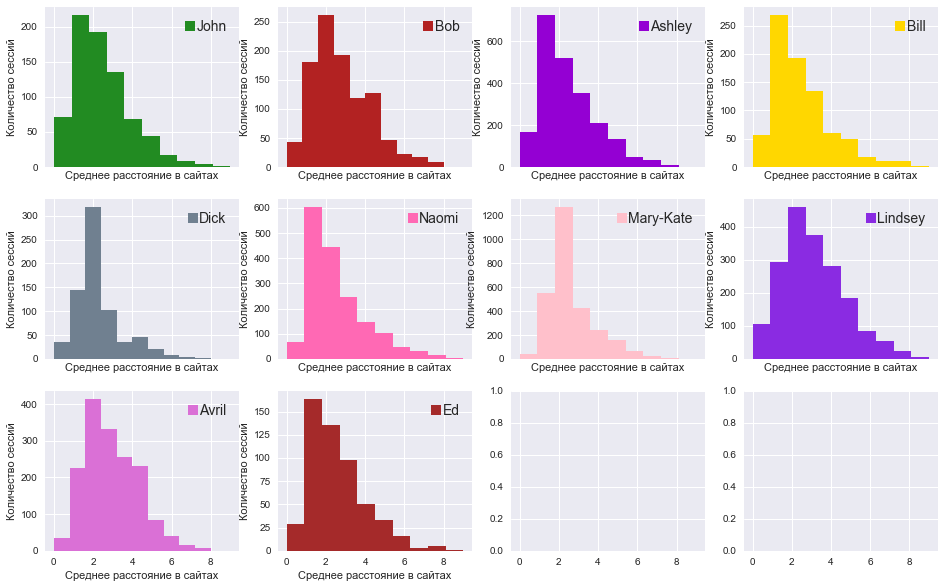

In [34]:
doPlot('repeat_dist_mean', 'Среднее расстояние в сайтах')

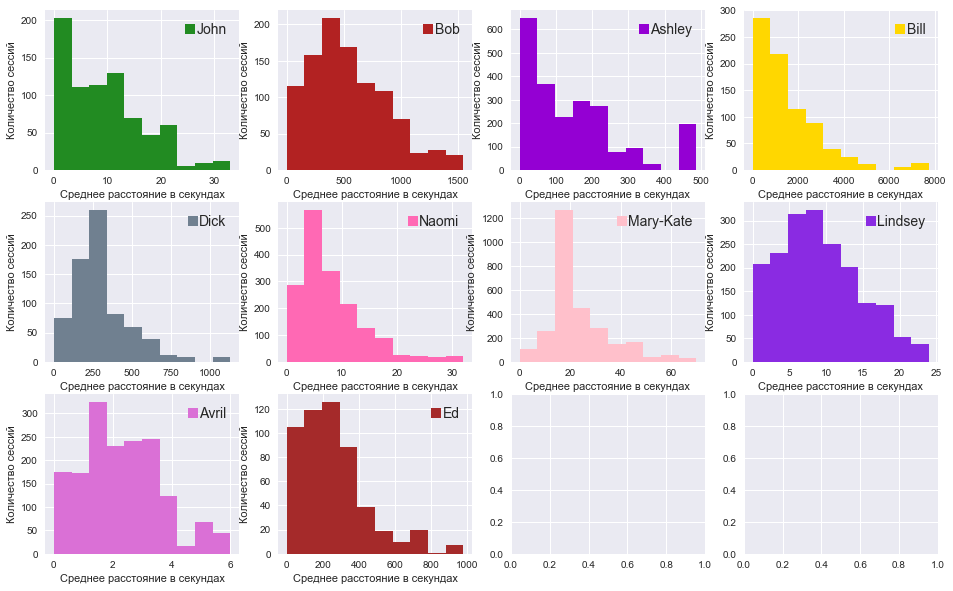

In [35]:
doPlot('repeat_dist_mean_sec', 'Среднее расстояние в секундах', sharex=False)

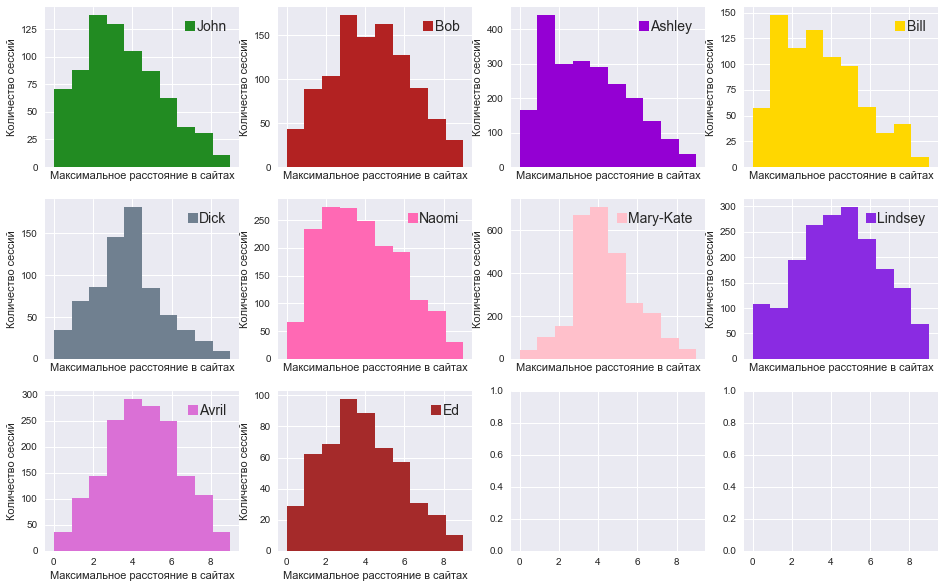

In [36]:
doPlot('repeat_dist_max', 'Максимальное расстояние в сайтах')

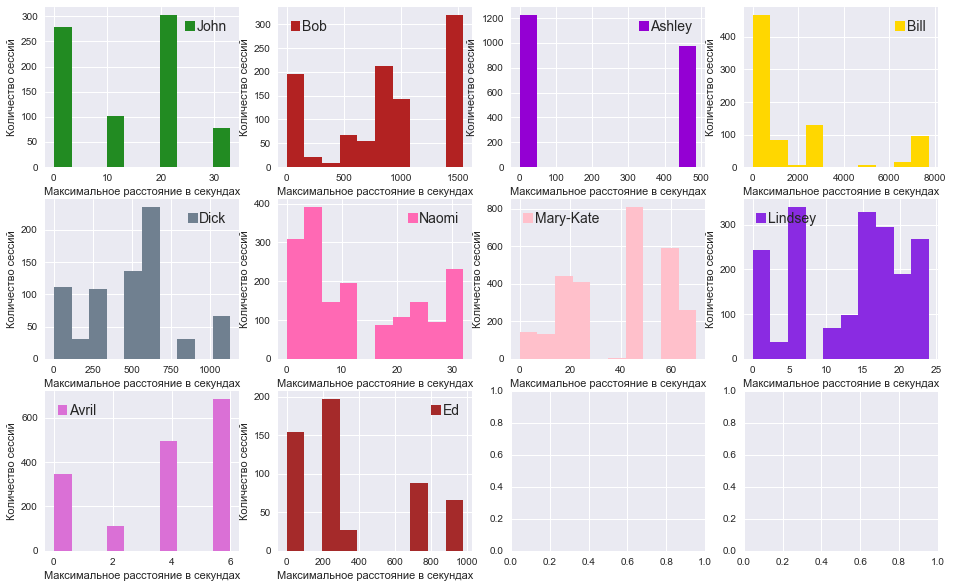

In [37]:
doPlot('repeat_dist_max_sec', 'Максимальное расстояние в секундах', sharex=False)

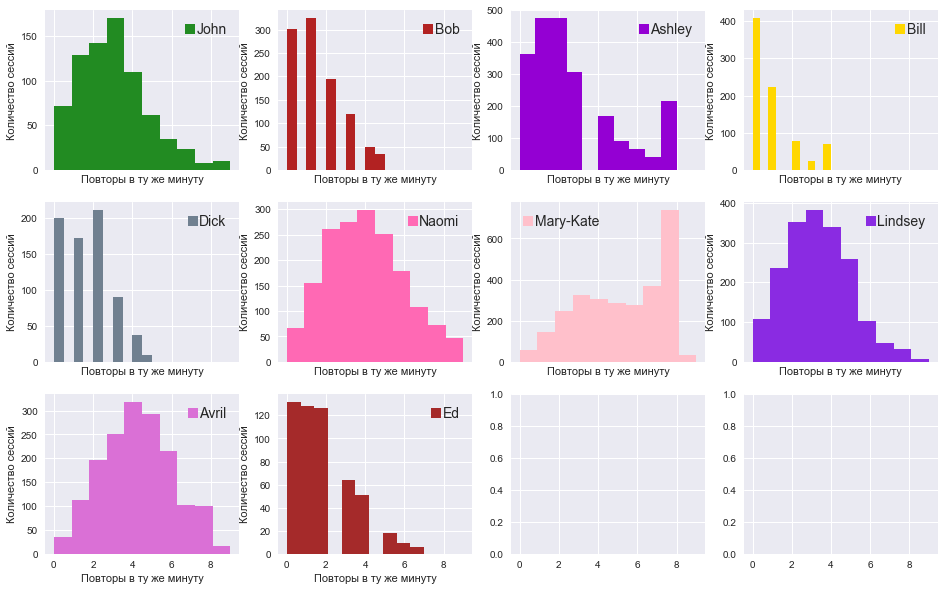

In [38]:
doPlot('repeat_same_min', 'Повторы в ту же минуту')

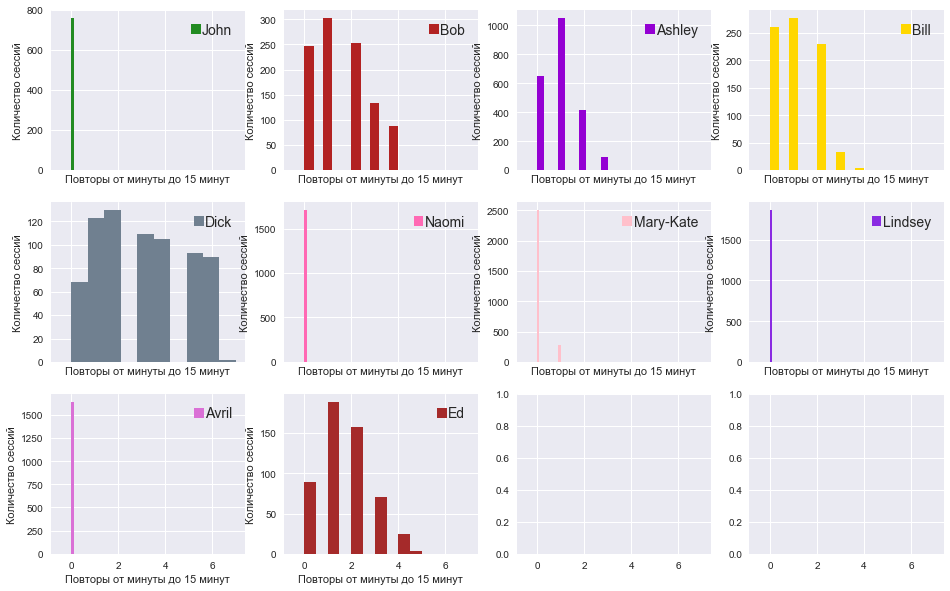

In [39]:
doPlot('repeat_same_15min', 'Повторы от минуты до 15 минут')

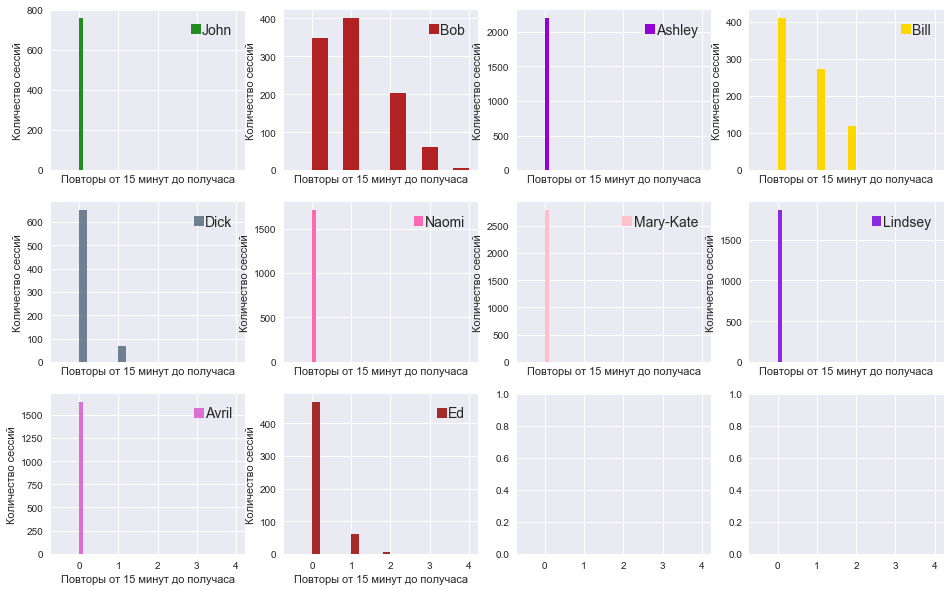

In [40]:
doPlot('repeat_same_30min', 'Повторы от 15 минут до получаса')

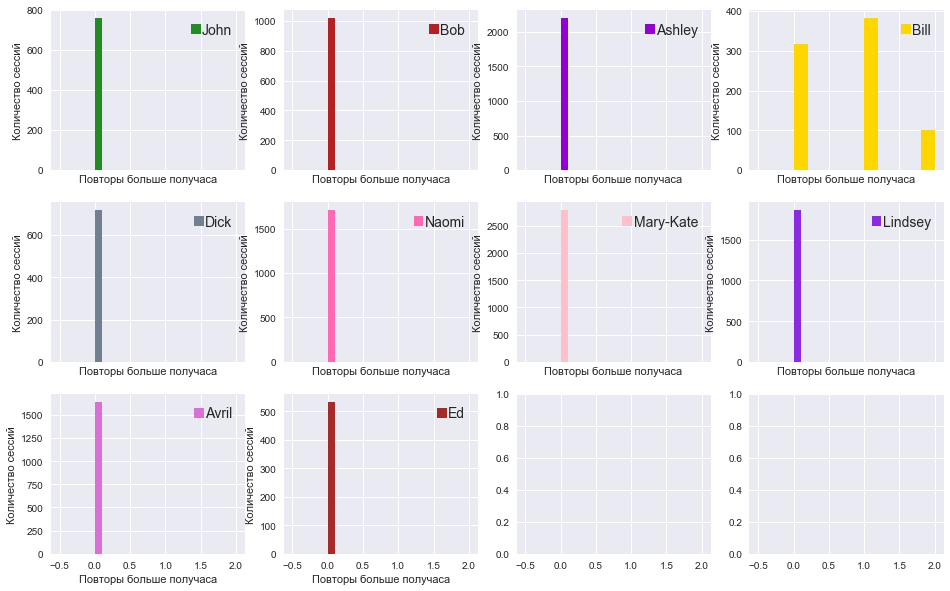

In [41]:
doPlot('repeat_over30min', 'Повторы больше получаса')

Судя по картинкам, время между повторными посещениями сайта, измеренное в сайтах, особо информации не дает - профили пользователей выглядят одинаково. А вот по остальным признакам пользователи различаются. иногда достаточно сильно, например, Bill - единственный пользователь с повторами в пределах одной сессии, различающимеся больше чем на полчаса.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [42]:
selected_features = ['session_timespan', 
                     '#unique_sites', 
                     'start_hour', 
                     'day_of_week']

new_selected_features = ['repeat_dist_mean_sec', 
                         'repeat_dist_max_sec', 
                         'repeat_same_min',
                         'repeat_same_15min',
                         'repeat_same_30min',
                         'repeat_over30min']

selected_features_10users = pd.concat(
    [train_data_10users[selected_features], new_train_data_10users[new_selected_features]], axis=1)

selected_features_150users = pd.concat(
    [train_data_150users[selected_features], new_train_data_150users[new_selected_features]], axis=1)

In [43]:
selected_features_10users.head()

,session_timespan,#unique_sites,start_hour,day_of_week,repeat_dist_mean_sec,repeat_dist_max_sec,repeat_same_min,repeat_same_15min,repeat_same_30min,repeat_over30min
0,33,5,8,4,9.0,22,5,0,0,0
1,284,10,8,4,0.0,0,0,0,0,0
2,258,7,8,4,11.0,23,3,0,0,0
3,30,6,8,4,8.0,10,4,0,0,0
4,6,9,8,4,1.0,1,1,0,0,0


In [44]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 